<a href="https://colab.research.google.com/github/bsenst/LoopOfHenle/blob/main/grouping_features_train_xgbmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://owncloud.ikem.cz/index.php/s/mFPJKwbgsOOFBsW/download
!7za x download

--2022-11-26 12:20:09--  https://owncloud.ikem.cz/index.php/s/mFPJKwbgsOOFBsW/download
Resolving owncloud.ikem.cz (owncloud.ikem.cz)... 212.67.92.39
Connecting to owncloud.ikem.cz (owncloud.ikem.cz)|212.67.92.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76420372 (73M) [application/x-7z-compressed]
Saving to: ‘download’

download            100%[===================>]  72.88M  11.1MB/s    in 7.4s    

2022-11-26 12:20:18 (9.82 MB/s) - ‘download’ saved [76420372/76420372]


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 76420372 bytes (73 MiB)

Extracting archive: download
--
Path = download
Type = 7z
Physical Size = 76420372
Headers Size = 221
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% - Dg from report.xlsx

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("LabsALL 2015-2022.csv", sep=";")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
def format_date(row):
    day, month, year = row.split(".")
    return f"{year}-{month}-{day}"
df.EntryDate = pd.to_datetime(df.EntryDate.apply(format_date))
df["pr_id"]= df.Patient.astype(str) + "_"+df.Report.astype(str)

In [5]:
df = df[~df.ValueNumber.isna()]

In [6]:
df

,Patient,Report,ID,EntryDate,EntryTime,Code,NCLP,Analyte,ValueNumber,ValueText,RefHigh,RefLow,Unit,pr_id
2,324729,1453155,18244355,2015-04-16,30.12.1899 7:31:00,NaN,3482.0,s_vápník celk.,2.37,NaN,2.55,2.15,mmol/l,324729_1453155
3,324729,1453155,18244356,2015-04-16,30.12.1899 7:31:00,NaN,2618.0,s_fosfor,1.32,NaN,1.23,0.71,mmol/l,324729_1453155
4,324729,1453155,18244357,2015-04-16,30.12.1899 7:31:00,NaN,3940.0,s_hořčík,0.75,NaN,0.94,0.71,mmol/l,324729_1453155
5,324729,1453155,18244358,2015-04-16,30.12.1899 7:31:00,NaN,8574.0,s_kreatinin,138.9,NaN,104.0,64.0,umol/l,324729_1453155
6,324729,1453155,18244359,2015-04-16,30.12.1899 7:31:00,NaN,1896.0,p_glukóza (NaF),10.36,NaN,5.59,3.60,mmol/l,324729_1453155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679291,335472,26490462,140942845,2022-05-13,30.12.1899 6:47:00,NaN,14011.0,U_epitelie dlaž.UF,1,NaN,20.0,0,/µL,335472_26490462
8679293,335472,26490462,140942847,2022-05-13,30.12.1899 6:47:00,NaN,3386.0,U_shluky leukocytů UF,0,NaN,NaN,NaN,arb.j.,335472_26490462
8679295,335472,26490462,140942849,2022-05-13,30.12.1899 6:47:00,NaN,9322.0,U_leukocyty UF,5,NaN,10.0,0,/µL,335472_26490462
8679296,335472,26490462,140942850,2022-05-13,30.12.1899 6:47:00,NaN,3078.0,s_kys.močová,327,NaN,420.0,210,µmol/l,335472_26490462


In [7]:
nclp_analytes = df[["NCLP","Analyte"]].groupby("NCLP").Analyte.unique().explode().drop_duplicates().reset_index().values

In [8]:
analytes_nclp_mapping = dict(zip(nclp_analytes[:,1], nclp_analytes[:,0]))
nclp_analytes_mapping = dict(zip(nclp_analytes[:,0], nclp_analytes[:,1]))

In [9]:
df_nan_nclp = df[df.NCLP.isna()].copy()

In [10]:
df_nan_nclp.NCLP = df_nan_nclp.Analyte.apply(lambda x: analytes_nclp_mapping[x] if x in analytes_nclp_mapping else -999)

In [11]:
df_new = pd.concat([df[~df.NCLP.isna()],df_nan_nclp[~(df_nan_nclp.NCLP == -999)]])

In [12]:
#units = df[["NCLP","Unit"]].groupby("NCLP").Unit.unique()
#units[units.apply(lambda x: len(x) > 1)].tail(60)

In [13]:

df_new.to_csv("cleaned_labs.csv.gzip", index=False, compression="gzip")

In [14]:
used_columns = ['Patient', 'Report','EntryDate', 'NCLP',
       'Analyte', 'ValueNumber', 'Unit',
       'pr_id']
df_new = df_new[used_columns]

# Download dgs

In [15]:
dgs = pd.read_excel("Dg from report.xlsx")
dgs["EntryDate"] = dgs.Date
dgs["parsed_dgs"] = dgs.mainDgCode.apply(lambda x: x.split(":")[0] if str(x).find(":")>0 else None)

In [16]:
n18_patients = dgs[dgs.parsed_dgs.apply(lambda x: x[:3]=="N18" if x else None).fillna(False)].Patient.unique()
dgs = dgs[dgs.Patient.isin(n18_patients)]
labs_n18 = df[df.Patient.isin(dgs.Patient.unique())]

# look at CKD time series

In [17]:
df_ckd = df_new[df_new.Patient.isin(labs_n18.Patient.unique())].copy()

In [18]:
ckd_data =df_ckd.pivot_table(index="pr_id",columns="NCLP", values="ValueNumber", aggfunc="first")
ckd_data = ckd_data.merge(df_ckd[["pr_id","EntryDate"]].drop_duplicates(), on="pr_id")

ckd_data["p_id"] = ckd_data.pr_id.apply(lambda x: int(x.split("_")[0]))
for col in ckd_data.columns[1:-2]:
    ckd_data[col] = ckd_data[col].apply(lambda x: pd.to_numeric(x, errors='coerce'))

ckd_data_grouped = ckd_data.groupby(["p_id",pd.Grouper(key="EntryDate",freq="1M")]).mean()

In [19]:
nclp_nan_ratio = ckd_data_grouped.isna().mean().sort_values()

In [20]:
feature_columns = nclp_nan_ratio[nclp_nan_ratio <=0.5].index

In [21]:
ckd_data_grouped[feature_columns].to_csv("ckd_grouped.csv.gzip", index=True, compression="gzip")

In [22]:
ckd_data_grouped[feature_columns]

8574.0   3086.0   5254.0   2688.0   4769.0   13808.0  \
p_id    EntryDate                                                          
10304   2015-02-28    113.3      8.1     3.94    256.0     15.0      5.6   
        2015-05-31    112.0      7.9     4.25    223.0     14.2      5.6   
        2015-06-30      NaN      NaN      NaN    251.0     14.1      5.1   
        2015-11-30    115.7      8.9     3.76    235.0     14.2      5.5   
        2016-03-31      NaN      NaN      NaN    246.0     14.9      4.5   
...                     ...      ...      ...      ...      ...      ...   
1254969 2021-11-30     83.4      5.4     4.30    332.0     12.8      8.9   
        2021-12-31     80.4      5.4     4.17    293.0     12.2      6.1   
        2022-06-30     86.4      7.3     4.24    319.0     12.6     11.5   
        2022-08-31     89.1      7.2      NaN    243.0     12.5      5.7   
        2022-11-30     81.4      6.5     4.85    297.0     12.4     13.4   

                    1675.0   2419.0   2099.0   1991.0   ...  12369.0  12365.0  \
p_id    EntryDate                                       ...                     
10304   2015-02-28     4.31     84.5   0.3640    120.0  ...     3.59     1.36   
        2015-05-31     4.21     86.0   0.3620    120.0  ...     3.66     1.29   
        2015-06-30     4.48     83.7   0.3750    128.0  ...     3.15     1.29   
        2015-11-30     4.22     83.0   0.3505    119.5  ...     3.68     1.15   
        2016-03-31     4.18     83.7   0.3500    117.0  ...     2.83     1.12   
...                     ...      ...      ...      ...  ...      ...      ...   
1254969 2021-11-30     4.36     89.9   0.3920    129.0  ...     5.58     2.33   
        2021-12-31     4.11     89.3   0.3670    120.0  ...     3.76     1.53   
        2022-06-30     4.05     89.6   0.3630    123.0  ...    10.74     0.61   
        2022-08-31     4.05     89.9   0.3640    123.0  ...     3.36     1.71   
        2022-11-30     4.08     91.7   0.3740    125.0  ...    12.56     0.64   

                    18029.0  18027.0  12449.0  12460.0  12483.0  12478.0  \
p_id    EntryDate                                                          
10304   2015-02-28      0.4     0.02      0.5      2.8     64.0      8.5   
        2015-05-31      0.5     0.03      0.5      3.7     64.9      8.0   
        2015-06-30      0.4     0.02      0.6      3.9     61.9      8.3   
        2015-11-30      0.2     0.01      0.5      3.7     65.1     10.3   
        2016-03-31      0.0     0.00      0.4      4.4     62.7      7.7   
...                     ...      ...      ...      ...      ...      ...   
1254969 2021-11-30      0.3     0.03      0.7      2.8     62.9      7.3   
        2021-12-31      0.2     0.01      1.2      4.4     61.8      7.4   
        2022-06-30      0.4     0.05      0.2      0.0     93.7      0.8   
        2022-08-31      0.2     0.01      0.5      2.1     59.5      7.6   
        2022-11-30      0.4     0.05      0.2      0.0     94.0      1.0   

                    12471.0  543.0    
p_id    EntryDate                     
10304   2015-02-28     24.2     2.19  
        2015-05-31     22.9     1.96  
        2015-06-30     25.3      NaN  
        2015-11-30     20.4     2.22  
        2016-03-31     24.8      NaN  
...                     ...      ...  
1254969 2021-11-30     26.3     1.13  
        2021-12-31     25.2     0.97  
        2022-06-30      5.3     1.08  
        2022-08-31     30.3      NaN  
        2022-11-30      4.8     0.97  

[2005 rows x 34 columns]

# get other patients

In [23]:
dgs["high_level_dgs"] = dgs.parsed_dgs.apply(lambda x: x.split(".")[0] if x else None)
other_N18_dgs=dgs[dgs.Patient.isin(n18_patients)].high_level_dgs.value_counts()

In [24]:
common_N18_dgs = other_N18_dgs.head(20).index

In [25]:
symptotic_patients = dgs[dgs.high_level_dgs.isin(common_N18_dgs)].Patient

In [27]:
# df_non_ckd

In [28]:
df_non_ckd = df[(~df.Patient.isin(symptotic_patients))&(df.NCLP.isin(feature_columns))][used_columns].copy()

In [29]:
del df
import gc
gc.collect()

689

In [30]:
non_ckd_data =df_non_ckd.pivot_table(index="pr_id",columns="NCLP", values="ValueNumber", aggfunc="first")
non_ckd_data = non_ckd_data.merge(df_non_ckd[["pr_id","EntryDate"]].drop_duplicates(), on="pr_id")

non_ckd_data["p_id"] = non_ckd_data.pr_id.apply(lambda x: int(x.split("_")[0]))
for col in non_ckd_data.columns[1:-2]:
    non_ckd_data[col] = non_ckd_data[col].apply(lambda x: pd.to_numeric(x, errors='coerce'))

non_ckd_data = non_ckd_data.groupby(["p_id",pd.Grouper(key="EntryDate",freq="1M")]).mean()

In [31]:
non_ckd_data[feature_columns].to_csv("non_ckd_grouped.csv.gzip", index=True, compression="gzip")

In [32]:

non_ckd_data.reset_index().p_id.unique().shape

(13645,)

In [33]:
nclp_analytes = dict(zip(nclp_analytes[:,0], nclp_analytes[:,1]))

In [34]:

del df_ckd, df_non_ckd

# Lets train

In [35]:
ckd_data_grouped = ckd_data_grouped[feature_columns]

In [36]:
non_ckd_data = non_ckd_data[feature_columns]

In [37]:
ckd_data_grouped["target"] = 1
non_ckd_data["target"] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
train_data = pd.concat([ckd_data_grouped,non_ckd_data])

In [39]:
train_data.to_csv("train_data.csv.gzip", index=True, compression="gzip")

In [41]:
# for col in train_data.columns

In [42]:
train_data = train_data.fillna(-999)

In [43]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_data, stratify=train_data.target)


In [44]:
ratio_CKD = 76/13_000

In [45]:
train_sample_weight = np.ones(train.shape[0])
train_sample_weight[train.target==0] = ratio_CKD

In [46]:
test_sample_weight = np.ones(test.shape[0])
test_sample_weight[test.target==0] = ratio_CKD

In [47]:

model = xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=1000, missing=-999)

In [80]:
print(*list((train.iloc[100:101,:-1]).values[0]), sep=", ")

-999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, 5.0, 1.044, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0


In [48]:


model.fit(train.iloc[:,:-1], train.target, sample_weight=train_sample_weight,
          eval_set=[(train.iloc[:,:-1], train.target),(test.iloc[:,:-1], test.target)],
          sample_weight_eval_set=[train_sample_weight, test_sample_weight], early_stopping_rounds=100)


[0]	validation_0-error:0.104804	validation_1-error:0.128267
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.102066	validation_1-error:0.128205
[2]	validation_0-error:0.100273	validation_1-error:0.123522
[3]	validation_0-error:0.099319	validation_1-error:0.126256
[4]	validation_0-error:0.099984	validation_1-error:0.122404
[5]	validation_0-error:0.099126	validation_1-error:0.117247
[6]	validation_0-error:0.099317	validation_1-error:0.119196
[7]	validation_0-error:0.101317	validation_1-error:0.119832
[8]	validation_0-error:0.101396	validation_1-error:0.120727
[9]	validation_0-error:0.102949	validation_1-error:0.122628
[10]	validation_0-error:0.103337	validation_1-error:0.123016
[11]	validation_0-error:0.101821	validation_1-error:0.119289
[12]	validation_0-error:0.102276	validation_1-error:0.119747
[13]	validation_0-error:0.101617	validation_1-error:0.1

XGBClassifier(learning_rate=0.05, max_depth=5, missing=-999, n_estimators=1000)

In [49]:

import pickle

with open("model_weighted.pkl", "wb") as f:
    pickle.dump(model, f)

In [50]:

from sklearn.metrics import precision_recall_fscore_support


y_pred = model.predict(test.iloc[:,:-1])

precision_recall_fscore_support(test.target, y_pred, sample_weight=test_sample_weight)[:3]

(array([0.87220121, 0.90970248]),
 array([0.8141054 , 0.94011976]),
 array([0.84215256, 0.92466104]))

In [63]:
test.iloc[:,:-1]

,,8574.0,3086.0,5254.0,2688.0,4769.0,13808.0,1675.0,2419.0,2099.0,1991.0,...,12369.0,12365.0,18029.0,18027.0,12449.0,12460.0,12483.0,12478.0,12471.0,543.0
p_id,EntryDate,,,,,,,,,,,,,,,,,,,,,
42198,2018-06-30,87.2,9.6,-999.00,214.0,13.4,12.4,4.94,89.7,0.443,151.0,...,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.87
1213024,2016-07-31,69.2,1.7,4.95,185.0,13.5,6.4,4.92,98.4,0.484,172.0,...,4.11,1.17,-999.0,-999.0,0.9,4.5,64.3,12.0,18.3,1.40
41412,2021-02-28,94.0,3.3,-999.00,242.0,22.7,9.0,4.09,79.2,0.324,98.0,...,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.20
589476,2022-03-31,93.1,7.7,-999.00,238.0,13.9,14.9,3.99,91.7,0.366,121.0,...,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.77
1204096,2015-10-31,115.3,4.9,4.27,149.0,14.1,7.3,4.96,91.3,0.453,150.0,...,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157674,2017-12-31,-999.0,-999.0,-999.00,-999.0,-999.0,-999.0,-999.00,-999.0,-999.000,-999.0,...,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00
73948,2015-07-31,-999.0,-999.0,-999.00,-999.0,-999.0,-999.0,-999.00,-999.0,-999.000,-999.0,...,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.10
141211,2022-06-30,98.5,7.7,3.47,-999.0,-999.0,-999.0,-999.00,-999.0,-999.000,-999.0,...,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00


In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43520 entries, (42198, Timestamp('2018-06-30 00:00:00')) to (1251984, Timestamp('2019-01-31 00:00:00'))
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   8574.0   43520 non-null  float64
 1   3086.0   43520 non-null  float64
 2   5254.0   43520 non-null  float64
 3   2688.0   43520 non-null  float64
 4   4769.0   43520 non-null  float64
 5   13808.0  43520 non-null  float64
 6   1675.0   43520 non-null  float64
 7   2419.0   43520 non-null  float64
 8   2099.0   43520 non-null  float64
 9   1991.0   43520 non-null  float64
 10  4726.0   43520 non-null  float64
 11  16263.0  43520 non-null  float64
 12  18895.0  43520 non-null  float64
 13  5272.0   43520 non-null  float64
 14  3078.0   43520 non-null  float64
 15  582.0    43520 non-null  float64
 16  17339.0  43520 non-null  float64
 17  921.0    43520 non-null  float64
 18  1961.0   43520 non-null  float64
 19  3410.0   4

In [56]:
[nclp_analytes_mapping[i] for i in train_data.columns[:-1]]

['S-kreatinin',
 'S-urea',
 'S-draslík (K)',
 'trombo',
 'anizo ERY-CV',
 'Leukocyty WBC',
 'Erytrocyty RBC',
 'MCV (střední objem ery)',
 'Hkt',
 'Hemoglobin Hb',
 'Objem dest.',
 'B_Thr_Aniz_SD',
 'B_Thr velké>12fl',
 'S-sodík (Na)',
 'S-kyselina močová\xa0',
 'S-ALT',
 'eGFR-CKD-EPI',
 'S-AST',
 'GMT',
 'pH moč',
 'U_spec.hmotnost',
 'Monocyty Abs',
 'Eozinofily Abs',
 'Bazofily Abs',
 'Neutrofily Abs',
 'Lymfocyty Abs',
 'B_Nezr.gran.rel',
 'B_Nezr.gran.abs',
 'Bazofilní segmenty',
 'Eozinofily  % 5P',
 'Neutrofilní segmenty % 5P',
 'Monocyty % 5P',
 'Lymfocyty % 5P',
 'Alkalická foshatáza (ALP)']

In [57]:
cp ./*.gzip drive/MyDrive/ikem_hackathon/data

cp: target 'drive/MyDrive/ikem_hackathon/data' is not a directory


In [58]:
cp ./*.pkl drive/MyDrive/ikem_hackathon/data


cp: cannot create regular file 'drive/MyDrive/ikem_hackathon/data': No such file or directory


     |████████████████████████████████| 569 kB 5.1 MB/s 


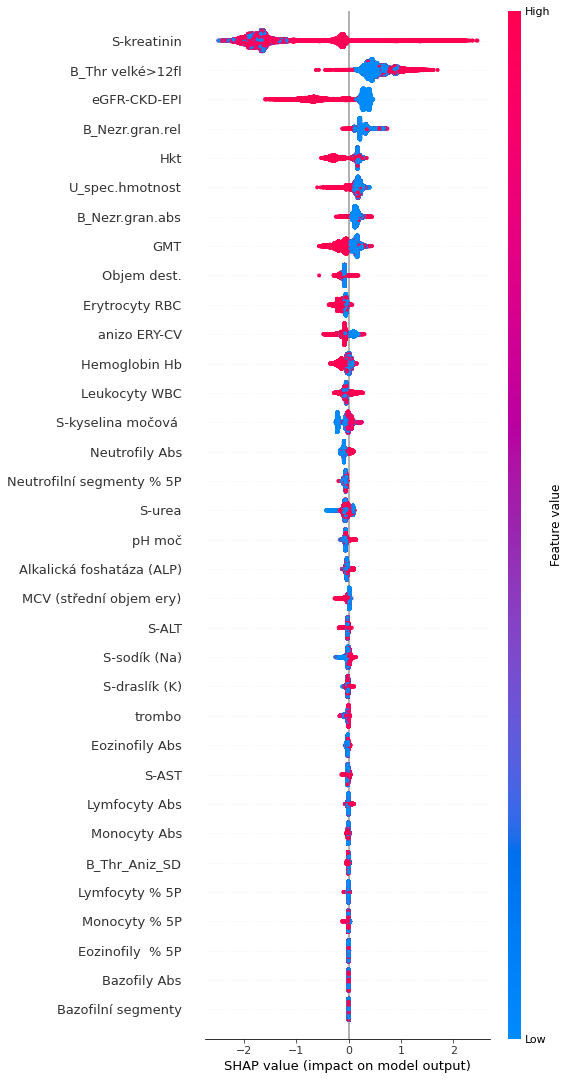

In [59]:



!pip install shap -q
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test.iloc[:,:-1])

shap.summary_plot(shap_values, test.iloc[:,:-1], max_display=100, feature_names=[nclp_analytes[i] for i in train_data.columns[:-1]])

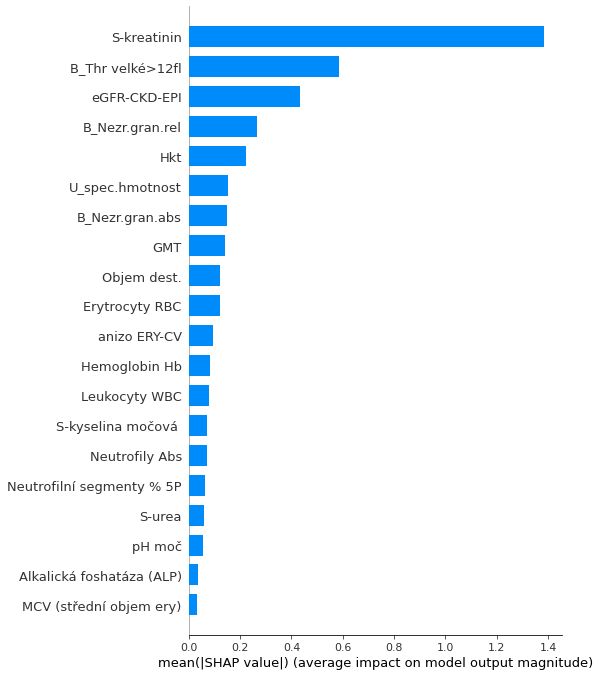

In [60]:

shap.summary_plot(shap_values, test.iloc[:,:-1], plot_type="bar", feature_names = [nclp_analytes[i] for i in train_data.columns[:-1]])